In [42]:
import pandas as pd
import sqlite3 as sql
import datetime as dt
import uuid
import numpy as np
import seaborn as sn

1. score metrics

ERD
game_dim
game_reports
player_dim
game_rankings (game_uuid, player_id, rank)
current_scores_view

In [43]:
games_df = pd.read_csv('game_reports.csv', parse_dates=[2,3])
games_df['players'] = games_df['players'].apply(lambda x: x.split(" "))
games_df['player_count'] = games_df['players'].apply(lambda x: len(x))
games_df['game_length'] = games_df['game_end'] - games_df['game_start']
games_df['game_length_minutes'] = games_df['game_length'].dt.total_seconds()/60

player_games_df = games_df.explode('players')
player_games_df['place'] = player_games_df.groupby(['game_played', 'game_start'])['players'].expanding().count().values

In [44]:
player_games_df

,game_played,players,game_start,game_end,player_count,game_length,game_length_minutes,place
0,Revolution,Scoggins,2022-12-19 09:40:00,2022-12-19 10:16:00,3,0 days 00:36:00,36.0,1.0
0,Revolution,Zack,2022-12-19 09:40:00,2022-12-19 10:16:00,3,0 days 00:36:00,36.0,2.0
0,Revolution,Max,2022-12-19 09:40:00,2022-12-19 10:16:00,3,0 days 00:36:00,36.0,3.0
1,Quacks,Celeste,2022-12-19 09:45:00,2022-12-19 11:40:00,4,0 days 01:55:00,115.0,4.0
1,Quacks,Brenna,2022-12-19 09:45:00,2022-12-19 11:40:00,4,0 days 01:55:00,115.0,1.0
1,Quacks,OtherJohn,2022-12-19 09:45:00,2022-12-19 11:40:00,4,0 days 01:55:00,115.0,2.0
1,Quacks,Hamen,2022-12-19 09:45:00,2022-12-19 11:40:00,4,0 days 01:55:00,115.0,1.0
2,Netrunner,Skylar,2022-12-19 10:00:00,2022-12-19 11:00:00,2,0 days 01:00:00,60.0,2.0
2,Netrunner,Preston,2022-12-19 10:00:00,2022-12-19 11:00:00,2,0 days 01:00:00,60.0,3.0
3,Hive,Preston,2022-12-19 11:10:00,2022-12-19 11:40:00,2,0 days 00:30:00,30.0,4.0


In [45]:
games_df = pd.read_csv('game_reports.csv', parse_dates=[2,3])
games_df['players'] = games_df['players'].apply(lambda x: x.split(" "))
games_df['player_count'] = games_df['players'].apply(lambda x: len(x))
games_df['game_length'] = games_df['game_end'] - games_df['game_start']
games_df['game_length_minutes'] = games_df['game_length'].dt.total_seconds()/60

player_games_df = games_df.explode('players')
player_games_df['place'] = player_games_df.groupby(['game_played', 'game_start'], sort=False)['players'].expanding().count().values
#t * (1+((1-p)/(2n-2))) where t = time, p = place order, and n = # of players
t = player_games_df['game_length_minutes']
p = player_games_df['place']
n = player_games_df['player_count']
player_games_df['score'] = np.round(t * (1+((1-p)/(2*n-2))))
player_games_df


,game_played,players,game_start,game_end,player_count,game_length,game_length_minutes,place,score
0,Revolution,Scoggins,2022-12-19 09:40:00,2022-12-19 10:16:00,3,0 days 00:36:00,36.0,1.0,36.0
0,Revolution,Zack,2022-12-19 09:40:00,2022-12-19 10:16:00,3,0 days 00:36:00,36.0,2.0,27.0
0,Revolution,Max,2022-12-19 09:40:00,2022-12-19 10:16:00,3,0 days 00:36:00,36.0,3.0,18.0
1,Quacks,Celeste,2022-12-19 09:45:00,2022-12-19 11:40:00,4,0 days 01:55:00,115.0,1.0,115.0
1,Quacks,Brenna,2022-12-19 09:45:00,2022-12-19 11:40:00,4,0 days 01:55:00,115.0,2.0,96.0
1,Quacks,OtherJohn,2022-12-19 09:45:00,2022-12-19 11:40:00,4,0 days 01:55:00,115.0,3.0,77.0
1,Quacks,Hamen,2022-12-19 09:45:00,2022-12-19 11:40:00,4,0 days 01:55:00,115.0,4.0,58.0
2,Netrunner,Skylar,2022-12-19 10:00:00,2022-12-19 11:00:00,2,0 days 01:00:00,60.0,1.0,60.0
2,Netrunner,Preston,2022-12-19 10:00:00,2022-12-19 11:00:00,2,0 days 01:00:00,60.0,2.0,30.0
3,Hive,Preston,2022-12-19 11:10:00,2022-12-19 11:40:00,2,0 days 00:30:00,30.0,1.0,30.0


In [47]:
player_games_df.groupby('players')['score'].sum().sort_values(ascending=False)

players
Zack         336.0
Max          326.0
Skylar       279.0
J            277.0
Paul         263.0
Preston      260.0
Les          258.0
OtherJohn    232.0
Brenna       206.0
Caitlin      172.0
Celeste      155.0
Dane         138.0
Meghann      116.0
Scoggins     111.0
Hamen         88.0
Reed          52.0
Jesse         45.0
Matt          45.0
Name: score, dtype: float64

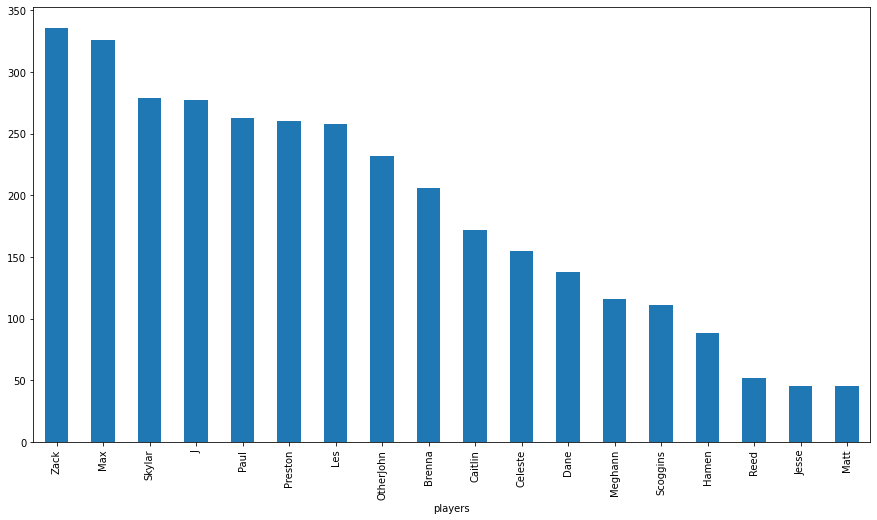

In [46]:
ranking = player_games_df.groupby('players')['score'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(15, 8))

In [5]:
game = ('Dune Imperium', ('Les', 'Zack', 'Paul', 'Skylar'), '2022/12/1 13:00:00', '2022/12/1 15:25:00')
game_uuid = str(uuid.uuid4())
game_list = [(game_uuid, game[0], place, player, game[2], game[3]) for place, player in enumerate(game[1])]

In [6]:
pd.DataFrame(game_list, columns=['game_id', 'game_played', 'player', 'place_order', 'game_start', 'game_end'])

,game_id,game_played,player,place_order,game_start,game_end
0,015cc072-417b-463f-b12f-b4147f3f02d4,Dune Imperium,0,Les,2022/12/1 13:00:00,2022/12/1 15:25:00
1,015cc072-417b-463f-b12f-b4147f3f02d4,Dune Imperium,1,Zack,2022/12/1 13:00:00,2022/12/1 15:25:00
2,015cc072-417b-463f-b12f-b4147f3f02d4,Dune Imperium,2,Paul,2022/12/1 13:00:00,2022/12/1 15:25:00
3,015cc072-417b-463f-b12f-b4147f3f02d4,Dune Imperium,3,Skylar,2022/12/1 13:00:00,2022/12/1 15:25:00


In [7]:
con = sql.connect("tutorial.db")

In [8]:
cur = con.cursor()

In [9]:
cur.execute("CREATE TABLE game_reports(game_id, game_played, player, place_order, game_start, game_end)")

OperationalError: table game_reports already exists

In [10]:
res = cur.execute("select * from sqlite_master")

In [11]:
res.fetchall()

[('table',
  'game_reports',
  'game_reports',
  3,
  'CREATE TABLE game_reports(game_id, game_played, player, place_order, game_start, game_end)')]

In [43]:
game1 = pd.DataFrame(game_list, columns=['game_id', 'game_played', 'player', 'place_order', 'game_start', 'game_end'])

In [52]:
game1.to_sql('game_reports', con, if_exists='append', index=False, method='multi')

4

In [53]:
res = cur.execute("select * from game_reports")
res.fetchall()

[('e17eb5f1-f941-455a-b21a-7a9fb06fce81',
  'Dune Imperium',
  0,
  'Les',
  '2022/12/1 13:00:00',
  '2022/12/1 15:25:00'),
 ('e17eb5f1-f941-455a-b21a-7a9fb06fce81',
  'Dune Imperium',
  1,
  'Zack',
  '2022/12/1 13:00:00',
  '2022/12/1 15:25:00'),
 ('e17eb5f1-f941-455a-b21a-7a9fb06fce81',
  'Dune Imperium',
  2,
  'Paul',
  '2022/12/1 13:00:00',
  '2022/12/1 15:25:00'),
 ('e17eb5f1-f941-455a-b21a-7a9fb06fce81',
  'Dune Imperium',
  3,
  'Skylar',
  '2022/12/1 13:00:00',
  '2022/12/1 15:25:00')]